In [1]:
import numpy as np
import pandas as pd
from pgmpy.readwrite import BIFReader
import matplotlib.pyplot as plt
import itertools as it
from pgmpy.inference import VariableElimination
from tqdm import tqdm
from collections import defaultdict

In [2]:
reader = BIFReader("data/cancer.bif")

In [3]:
reader.get_states()

{'Pollution': ['low', 'high'],
 'Smoker': ['True', 'False'],
 'Cancer': ['True', 'False'],
 'Xray': ['positive', 'negative'],
 'Dyspnoea': ['True', 'False']}

In [4]:
def direct_query(reader, evidence, prec=5):
    data = reader.get_states().copy()
    data = {k:list(filter(lambda x: k not in evidence.keys() or (x == evidence[k]), v)) for k, v in data.items()}
    all_names = sorted(data)
    combinations = it.product(*(data[name] for name in all_names))
    df = pd.DataFrame(combinations, columns=all_names)
    
#     print(df)
    
    prob = 0.0
    
    for i, row in df.iterrows():
        cur = 1.0
        for node in data.keys():
            cpd = reader.get_model().get_cpds(node)
            if node in reader.get_model().get_roots():
                cur *= eval('cpd.get_value({}="{}")'.format(node, row[node]))
            else:
                names_reduce = cpd.scope()
                cur *= eval("cpd.get_value({})".format(', '.join([x + '="' + row[x] + '"' for x in names_reduce])))
        prob += cur
    return round(prob, prec)

In [5]:
direct_ans = direct_query(reader, {
         'Smoker': 'True',
         'Xray': 'negative'
        })

In [6]:
direct_ans

0.23328

In [7]:
from toposort import toposort

def traverse(reader, order):
    evidence = {}
    
    
    for group in order:
        for node in group:
            cpd = reader.get_model().get_cpds(node).copy()
            evidence_set = cpd.variables.copy()
            evidence_set.remove(node)
            evidence_set = list(map(lambda x: (x, evidence[x]), evidence_set))
            cpd.reduce(evidence_set)
            values = reader.get_states()[node]
            value = np.random.choice(a=values, p=cpd.values)
            evidence[node] = value
            
    return evidence

In [8]:
def predict(reader, params, order, times=100):
    counter = 0.0
    
    for i in range(times):
        q = traverse(reader, order)
        counter += float(all(v == q[k] for k, v in params.items()))
    return counter / times

In [10]:
graph = defaultdict(set)
for edge in reader.get_edges():
    graph[edge[0]].add(edge[1])    
order = list(reversed(list(toposort(graph))))

In [14]:
predict(reader, {
         'Smoker': 'True',
         'Xray': 'negative'
        }, order, 400)

0.2525

In [122]:
xs = []
ys = []
    
for i in tqdm(range(1, 1000, 10)):
    xs.append(i)
    ys.append(predict(reader, {
         'Smoker': 'True',
         'Xray': 'negative'
        }, order, i))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [50:13<00:00, 30.14s/it]


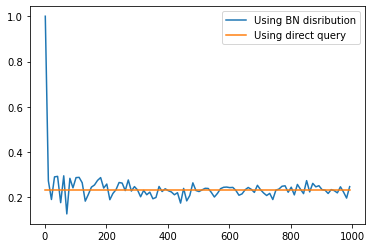

In [123]:
plt.plot(xs, ys, label='Using BN disribution')
plt.plot(xs, [direct_ans for _ in range(len(xs))], label='Using direct query')
plt.legend()
plt.show()

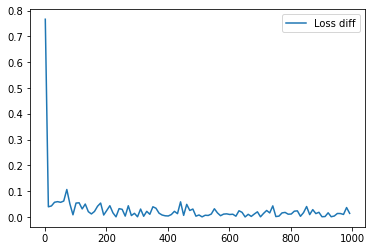

In [124]:
plt.plot(xs, abs(np.array(ys) - np.array([direct_ans for _ in range(len(xs))])), label='Loss diff')
plt.legend()
plt.show()